# ===================================================
# Notebook exploratoire
# ===================================================

## Librairies

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Grid2Op
import grid2op
from lightsim2grid import LightSimBackend
from grid2op.Observation import BaseObservation
from grid2op.Environment import Environment
from grid2op.Action import BaseAction

# Model
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor

c:\Users\marcd\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data et environnement

In [ ]:
def extract_features(obs: BaseObservation) -> pl.DataFrame:
    """
    Transforme une observation du réseau en DataFrame Polars avec noms de colonnes explicites.
    """
    # Création des noms de colonnes
    feature_names = (
        [f"gen_p_{i}" for i in range(len(obs.gen_p))] +
        [f"gen_q_{i}" for i in range(len(obs.gen_q))] +
        [f"load_p_{i}" for i in range(len(obs.load_p))] +
        [f"load_q_{i}" for i in range(len(obs.load_q))] +
        [f"topo_{i}" for i in range(len(obs.topo_vect))] +
        [f"rho_{i}" for i in range(len(obs.rho))]
    )
    
    # Concaténation des vecteurs en un seul vecteur
    feature_array = np.concatenate([
        obs.gen_p,
        obs.gen_q,
        obs.load_p,
        obs.load_q,
        obs.topo_vect,
        obs.rho
    ])
    
    # Transformation en DataFrame Polars
    df = pl.DataFrame([feature_array], schema=feature_names, orient="row")
    
    return df

# def extract_features(obs: BaseObservation) -> pl.DataFrame:
#     """Extrait un vecteur de features depuis une observation."""
#     return pl.from_numpy(
#         np.concatenate([
#             obs.gen_p,
#             obs.gen_q,
#             obs.load_p,
#             obs.load_q,
#             obs.topo_vect,
#             obs.rho,
#         ])
#     ).transpose()

def create_realistic_observation(episode_count: int, env: Environment) -> list[BaseObservation]:
    """Crée une liste d'observations réalistes avec actions 'rien faire'."""
    list_obs = []
    for _ in tqdm(range(episode_count)):
        obs = env.reset()
        list_obs.append(obs)
        for _ in range(env.chronics_handler.max_timestep()):
            obs, reward, done, info = env.step(env.action_space())
            if done:
                break
            list_obs.append(obs)
    return list_obs

def create_training_data(list_obs: list[BaseObservation], all_actions: list[BaseAction]):
    """Crée features et targets pour ML"""
    df_features = []
    df_targets = []
    for obs in tqdm(list_obs):
        action_score = []
        simulator = obs.get_simulator()
        for act in all_actions:
            sim_after_act = simulator.predict(act=act)
            n_obs = sim_after_act.current_obs
            action_score.append(n_obs.rho.max() if sim_after_act.converged else np.inf)
        df_targets.append(action_score)
        df_features.append(extract_features(obs))
    df_features = pl.concat(df_features)
    df_targets = pl.DataFrame(df_targets).transpose()
    df_targets.columns = [f"action_{i}" for i in range(df_targets.width)]

    return df_features, df_targets

In [ ]:
env = grid2op.make("l2rpn_case14_sandbox", backend=LightSimBackend(), n_busbar=3)

episode_count = 2
n_actions = 100

# Actions aléatoires + 'rien faire'
all_actions = [env.action_space.sample() for _ in range(n_actions)]
all_actions.append(env.action_space())

In [40]:
print("Example of pretty print for an action ;", all_actions[0])

Example of pretty print for an action ; This action will:
	 - NOT change anything to the injections
	 - Modify the generators with redispatching in the following way:
	 	 - Redispatch "gen_1_0" of 4.22 MW
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

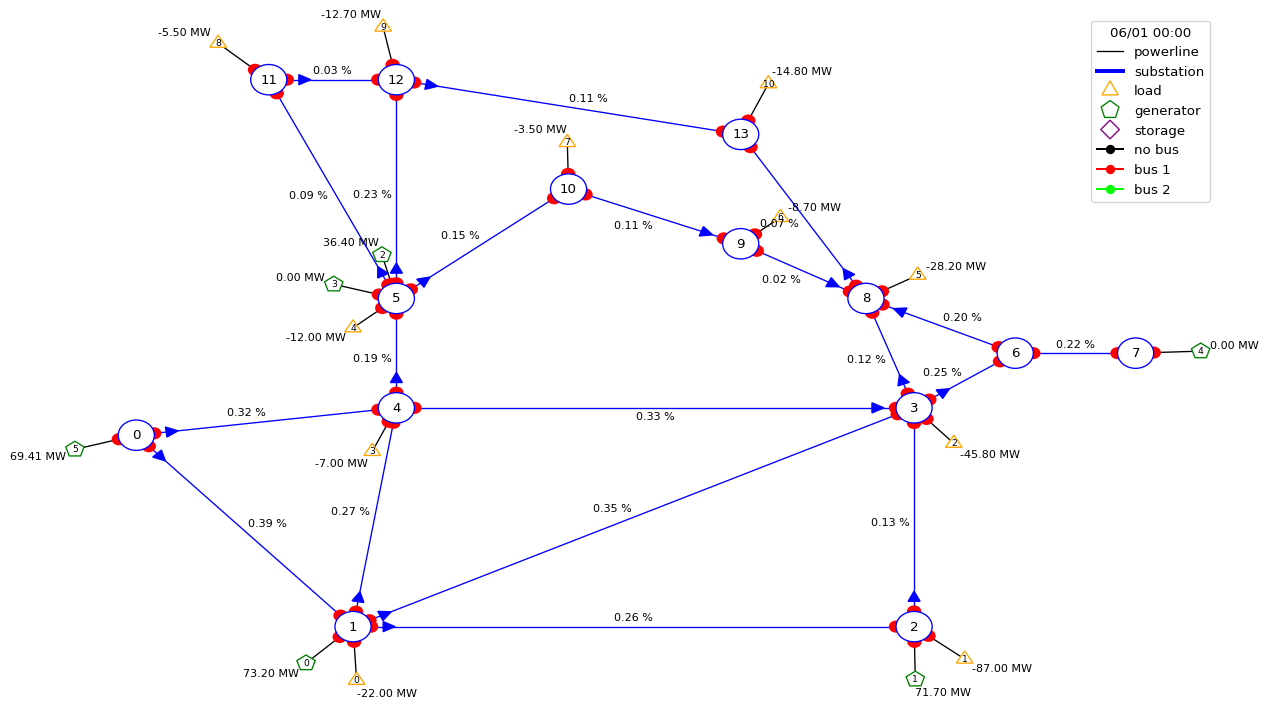

In [41]:
env.render()

In [ ]:
list_obs = create_realistic_observation(episode_count, env)
df_features, df_targets = create_training_data(list_obs, all_actions)

print("Dimensions features:", df_features.shape)
print("Dimensions targets :", df_targets.shape)

100%|██████████| 3808/3808 [08:03<00:00,  7.87it/s]


Dimensions features: (3808, 111)
Dimensions targets : (3808, 101)


In [43]:
df_targets.write_parquet("df_targets.parquet")
df_features.write_parquet("df_features.parquet")

In [44]:
df_targets

rho0,rho1,rho2,rho3,rho4,rho5,rho6,rho7,rho8,rho9,rho10,rho11,rho12,rho13,rho14,rho15,rho16,rho17,rho18,rho19,rho20,rho21,rho22,rho23,rho24,rho25,rho26,rho27,rho28,rho29,rho30,rho31,rho32,rho33,rho34,rho35,rho36,…,rho64,rho65,rho66,rho67,rho68,rho69,rho70,rho71,rho72,rho73,rho74,rho75,rho76,rho77,rho78,rho79,rho80,rho81,rho82,rho83,rho84,rho85,rho86,rho87,rho88,rho89,rho90,rho91,rho92,rho93,rho94,rho95,rho96,rho97,rho98,rho99,rho100
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.924752,inf,0.924473,1.738649,0.927738,inf,0.921295,0.924293,2.921079,0.924818,inf,0.928686,0.924796,1.223919,1.252364,0.924473,0.957245,1.022155,1.252364,0.920791,0.921908,0.951399,0.919581,2.921079,0.92869,0.924473,2.921079,0.924473,0.924473,1.280081,1.252364,0.924473,0.924473,inf,0.991759,inf,2.921079,…,inf,0.924435,1.18201,0.991759,inf,0.951399,1.672045,0.924797,inf,inf,0.925272,2.921079,inf,0.919581,0.924473,0.924473,0.924473,0.924473,0.923517,0.924761,0.921021,1.252364,1.910263,0.924473,0.924373,0.922037,inf,1.07932,0.919581,0.924627,1.043278,0.924291,0.922716,0.921845,0.957245,0.924295,0.924473
0.925601,inf,0.925324,1.751414,0.928577,inf,0.922157,0.925144,2.963777,0.925667,inf,0.929521,0.925645,1.223866,1.252578,0.925324,0.956519,1.017343,1.252578,0.921655,0.922768,0.950245,0.920567,2.963777,0.929525,0.925324,2.963777,0.925324,0.925324,1.276919,1.252578,0.925324,0.925324,inf,0.992912,inf,2.963777,…,inf,0.925285,1.171698,0.992912,inf,0.950245,1.698486,0.925646,inf,inf,0.92612,2.963777,inf,0.920567,0.925324,0.925324,0.925324,0.925324,0.924371,0.92561,0.921884,1.252578,1.913983,0.925324,0.925223,0.922793,inf,1.078207,0.920567,0.925477,1.043774,0.925142,0.923573,0.922705,0.956519,0.925146,0.925324
0.920969,inf,0.920692,1.749997,0.923939,inf,0.917531,0.920512,2.937955,0.921034,inf,0.924882,0.921013,1.218037,1.247549,0.920692,0.95134,1.014091,1.247549,0.917029,0.91814,0.960046,0.916391,2.937955,0.924886,0.920692,2.937955,0.920692,0.920692,1.272976,1.247549,0.920692,0.920692,inf,0.987906,inf,2.937955,…,inf,0.920653,1.186538,0.987906,inf,0.960046,1.686175,0.921014,inf,inf,0.921486,2.937955,inf,0.916391,0.920692,0.920692,0.920692,0.920692,0.919741,0.920977,0.917258,1.247549,1.904173,0.920692,0.920591,0.918325,inf,1.0716,0.916391,0.920845,1.038728,0.92051,0.918944,0.918078,0.95134,0.920514,0.920692
0.925759,inf,0.92548,1.749233,0.928747,inf,0.9223,0.9253,2.92392,0.925825,inf,0.929695,0.925803,1.225793,1.25437,0.92548,0.958971,1.025826,1.25437,0.921796,0.922914,0.950215,0.920984,2.92392,0.929699,0.92548,2.92392,0.92548,0.92548,1.286744,1.25437,0.92548,0.92548,inf,0.990192,inf,2.92392,…,inf,0.925441,1.186144,0.990192,inf,0.950215,1.67774,0.925804,inf,inf,0.926279,2.92392,inf,0.920984,0.92548,0.92548,0.92548,0.92548,0.924524,0.925768,0.922026,1.25437,1.900401,0.92548,0.925379,0.923055,inf,1.082343,0.920984,0.925634,1.044574,0.925297,0.923722,0.922851,0.958971,0.925301,0.92548
0.929973,inf,0.929695,1.767229,0.932952,inf,0.926524,0.929515,2.978619,0.930038,inf,0.933897,0.930017,1.231323,1.26099,0.929695,0.961445,1.028319,1.26099,0.926021,0.927136,0.94729,0.925305,2.978619,0.933901,0.929695,2.978619,0.929695,0.929695,1.289218,1.26099,0.929695,0.929695,inf,0.9949,inf,2.978619,…,inf,0.929656,1.197254,0.9949,inf,0.94729,1.712339,0.930018,inf,inf,0.930491,2.978619,inf,0.925305,0.929695,0.929695,0.929695,0.929695,0.928741,0.929982,0.926251,1.26099,1.914292,0.929695,0.929594,0.927164,inf,1.084825,0.925305,0.929848,1.049396,0.929512,0.927942,0.927073,0.961445,0.929516,0.929695
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.99904,inf,0.998941,1.057504,1.000073,inf,0.997846,0.998877,4.066898,0.99906,inf,1.000396,0.99905

In [45]:
df_features

gen_p_0,gen_p_1,gen_p_2,gen_p_3,gen_p_4,gen_p_5,gen_q_0,gen_q_1,gen_q_2,gen_q_3,gen_q_4,gen_q_5,load_p_0,load_p_1,load_p_2,load_p_3,load_p_4,load_p_5,load_p_6,load_p_7,load_p_8,load_p_9,load_p_10,load_q_0,load_q_1,load_q_2,load_q_3,load_q_4,load_q_5,load_q_6,load_q_7,load_q_8,load_q_9,load_q_10,topo_0,topo_1,topo_2,…,topo_40,topo_41,topo_42,topo_43,topo_44,topo_45,topo_46,topo_47,topo_48,topo_49,topo_50,topo_51,topo_52,topo_53,topo_54,topo_55,topo_56,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
81.400002,79.300003,5.3,0.0,0.0,82.246674,19.496038,71.340233,24.368923,24.368923,24.01807,-17.27466,21.9,85.800003,44.299999,6.9,11.9,28.5,8.8,3.5,5.4,12.6,14.4,15.4,59.700001,30.799999,4.8,8.3,19.4,6.1,2.4,3.9,8.8,10.5,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.34013,0.360423,0.272101,0.267226,0.828129,0.269201,0.343346,0.531516,0.495164,0.731675,0.288539,0.382659,0.289275,0.431878,0.396449,0.544602,0.533467,0.924473,0.453396,0.46154
82.5,80.699997,5.3,0.0,0.0,80.113495,19.162947,71.243042,24.402109,24.402109,24.112627,-16.656225,22.0,85.699997,44.900002,6.8,11.7,28.1,8.8,3.4,5.4,12.9,14.7,15.4,60.0,30.9,4.8,8.2,19.700001,6.1,2.5,3.8,8.9,10.3,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.326746,0.356591,0.263959,0.267204,0.829614,0.278238,0.340316,0.533229,0.496741,0.738767,0.290505,0.390571,0.29017,0.447009,0.396498,0.54363,0.531994,0.925324,0.455181,0.46067
82.699997,81.599998,5.4,0.0,0.0,79.293762,19.233862,72.06739,24.604052,24.604052,24.333878,-16.379263,22.0,86.300003,44.799999,7.0,11.7,28.0,8.8,3.5,5.5,12.4,14.8,15.4,60.799999,31.200001,4.9,8.3,20.0,6.3,2.4,3.8,8.9,10.5,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.322066,0.354571,0.26173,0.266428,0.828156,0.280012,0.337524,0.53956,0.498101,0.73516,0.289035,0.389768,0.296073,0.438327,0.405533,0.54143,0.529341,0.920692,0.459357,0.460031
81.199997,81.699997,5.5,0.0,0.0,83.309692,20.089237,72.811249,24.32811,24.32811,24.152327,-17.444201,22.0,88.099998,45.0,6.9,11.8,28.5,8.7,3.5,5.5,12.5,14.9,15.5,61.0,31.299999,4.8,8.3,19.5,6.2,2.4,3.8,8.7,10.3,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.346037,0.363183,0.27291,0.26872,0.831273,0.27232,0.348628,0.534556,0.496473,0.732376,0.277777,0.390334,0.291495,0.432514,0.402103,0.546279,0.534865,0.92548,0.45593,0.462792
83.099998,81.900002,5.7,0.0,0.0,81.110779,19.422855,73.018944,24.461641,24.461641,24.407396,-16.756819,22.0,87.300003,45.400002,6.9,11.8,28.5,8.8,3.4,5.5,12.8,15.1,15.3,61.400002,31.299999,4.8,8.0,20.1,6.1,2.4,3.9,8.8,10.4,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.331326,0.360288,0.268568,0.269959,0.837161,0.279832,0.346156,0.538806,0.50282,0.744448,0.283771,0.396378,0.296749,0.441963,0.4073,0.547093,0.536196,0.929695,0.460745,0.465798
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
69.400002,68.0,58.299999,13.8,9.1,67.357483,18.734512,94.039207,22.052109,22.052109,26.56752,-16.967211,22.700001,105.0,49.599998,8.2,11.6,31.4,10.3,4.1,7.0,15.6,16.299999,15.6,73.400002,35.200001,5.9,8.3,21.5,7.0,2.8,5.0,10.8,11.1,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.319332,0.250312,0.380039,0.19808,0.493211,0.204621,0.514898,0.915902,0.653262,0.998941,0.423748,0.305648,0.562604,0.622646,0.622266,0.298271,0.274628,0.115118,0.530127,0.398827
70.300003,67.099998,58.099998,14.9,9.5,62.906563,17.542288,93.835938,21.80135,21.80135,26.6

In [ ]:
df_targets = pd.read_parquet("df_targets.parquet")
df_features = pd.read_parquet("df_features.parquet")

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
display(df_features.describe())
display(df_targets.describe())

,gen_p_0,gen_p_1,gen_p_2,gen_p_3,gen_p_4,gen_p_5,gen_q_0,gen_q_1,gen_q_2,gen_q_3,...,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19
count,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,...,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000
mean,73.375131,71.830699,30.765966,4.838629,2.777206,70.713828,16.905991,78.102562,21.464613,21.464613,...,0.152822,0.300299,0.385424,0.483660,0.474512,0.420533,0.394449,0.454040,0.470010,0.391451
std,8.168439,8.038206,11.966430,7.796800,4.469651,8.459298,3.941863,9.200852,2.939043,2.939043,...,0.100520,0.040481,0.064800,0.063740,0.058812,0.068323,0.074284,0.212789,0.048533,0.065130
min,51.400002,50.400002,5.300000,0.000000,0.000000,46.899555,7.262211,55.730373,13.773619,13.773619,...,0.001076,0.201459,0.247568,0.351059,0.353332,0.238130,0.180645,0.059485,0.367480,0.230327
25%,67.800003,66.400002,23.500000,0.000000,0.000000,64.955904,13.649324,70.994095,19.233812,19.233812,...,0.071860,0.275335,0.333324,0.435040,0.428399,0.374540,0.342444,0.281520,0.429398,0.342201
50%,73.400002,71.699997,29.600000,0.000000,0.000000,70.647743,17.164850,78.722168,21.443686,21.443686,...,0.132373,0.299005,0.384761,0.479582,0.473903,0.420680,0.394389,0.448643,0.468863,0.392600
75%,79.400002,77.900002,40.000000,8.500000,4.900000,76.801863,19.898352,85.715534,23.853586,23.853586,...,0.224841,0.328774,0.432509,0.533397,0.517259,0.468690,0.446615,0.608626,0.506548,0.440878
max,98.000000,95.400002,58.599998,29.000000,17.299999,97.371086,29.009232,95.873329,29.681734,29.681734,...,0.496499,0.412407,0.595888,0.652420,0.648800,0.596154,0.595569,1.002160,0.590360,0.540574


,rho0,rho1,rho2,rho3,rho4,rho5,rho6,rho7,rho8,rho9,...,rho91,rho92,rho93,rho94,rho95,rho96,rho97,rho98,rho99,rho100
count,3808.000000,3808.0,3808.000000,3808.000000,3808.000000,3808.0,3808.000000,3808.000000,3808.000000,3808.000000,...,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000,3808.000000
mean,0.814901,inf,0.814126,1.314294,0.816225,inf,0.812920,0.813814,3.243975,0.814324,...,0.909643,0.811742,0.814185,0.846127,0.813811,0.813245,0.812871,0.824427,0.813816,0.814126
std,0.089988,NaN,0.090487,0.241467,0.089869,NaN,0.090511,0.090712,0.393235,0.090427,...,0.101358,0.091147,0.090485,0.097428,0.090714,0.090691,0.090738,0.092509,0.090711,0.090487
min,0.629779,inf,0.629693,0.803707,0.630732,inf,0.628684,0.629638,2.479268,0.629803,...,0.687881,0.627477,0.629742,0.643577,0.629637,0.629137,0.628862,0.636104,0.629639,0.629693
25%,0.742427,NaN,0.741748,1.144490,0.743905,NaN,0.740616,0.741437,2.915439,0.741856,...,0.829686,0.739002,0.741796,0.767485,0.741436,0.740956,0.740548,0.749696,0.741437,0.741748
50%,0.822744,NaN,0.821588,1.306950,0.824264,NaN,0.819758,0.821176,3.257825,0.821811,...,0.918275,0.819740,0.821688,0.856626,0.821173,0.819988,0.819634,0.835185,0.821177,0.821588
75%,0.886716,NaN,0.886628,1.477559,0.887676,NaN,0.885508,0.886552,3.566289,0.886735,...,0.979972,0.884739,0.886676,0.923611,0.886551,0.885730,0.885463,0.899528,0.886552,0.886628
max,1.008758,inf,1.008657,2.020522,1.009808,inf,1.007543,1.008592,4.120337,1.008778,...,1.214641,1.007176,1.008711,1.138827,1.008591,1.008039,1.007733,1.043671,1.008592,1.008657


Nombre de targets invalides (rho = inf) : 60928


## Modèle

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features,
    df_targets,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (3046, 111) (3046, 101)
Test : (762, 111) (762, 101)


In [70]:
max_valid = np.max(y_train[np.isfinite(y_train)])
y_train[~np.isfinite(y_train)] = max_valid + 0.1

max_valid = np.max(y_test[np.isfinite(y_test)])
y_test[~np.isfinite(y_test)] = max_valid + 0.1

In [91]:
# On crée le modèle
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1 
)

# On entraîne sur toutes les colonnes de y_train
rf_model.fit(X_train, y_train)

# Prédiction
y_pred = rf_model.predict(X_test)

# RMSE global (moyenne sur toutes les actions)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.02552815256968824


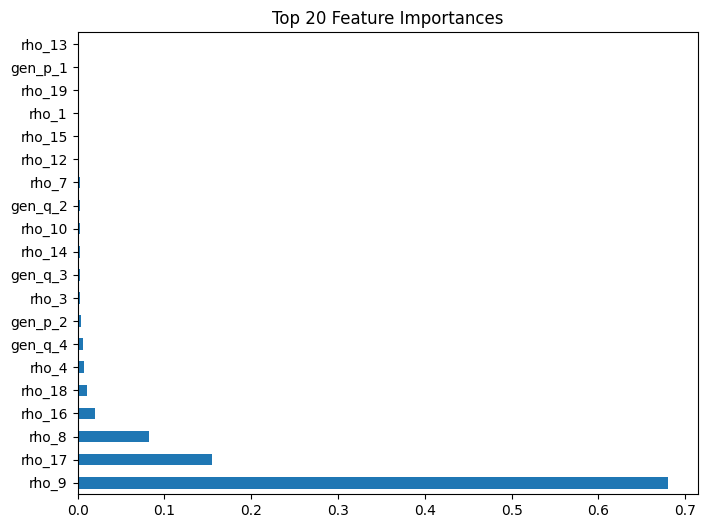

In [95]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.nlargest(20).plot(kind="barh", figsize=(8, 6))
plt.title("Top 20 Feature Importances")
plt.show()

### Tuning

In [ ]:
# def objective(trial):
#     n_estimators = trial.suggest_int("n_estimators", 50, 300)
#     max_depth = trial.suggest_int("max_depth", 3, 20)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
#     max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42,
#         n_jobs=-1
#     )

#     # Cross-validation
#     cv = KFold(n_splits=3, shuffle=True, random_state=42)
#     scores = cross_val_score(
#         model,
#         X_train,
#         y_train,
#         scoring="neg_root_mean_squared_error",  
#         cv=cv,
#         n_jobs=-1
#     )

#     return -scores.mean()


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=30, show_progress_bar=True)

# print("✅ Best RMSE:", study.best_value)
# print("Best params:", study.best_params)

In [ ]:
# best_params = study.best_params
# best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
# best_model.fit(X_train, y_train)

# y_pred = best_model.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print(f"🎯 Test RMSE (Optuna best): {rmse:.5f}")

🎯 Test RMSE (Optuna best): 0.02567


## Visualisations

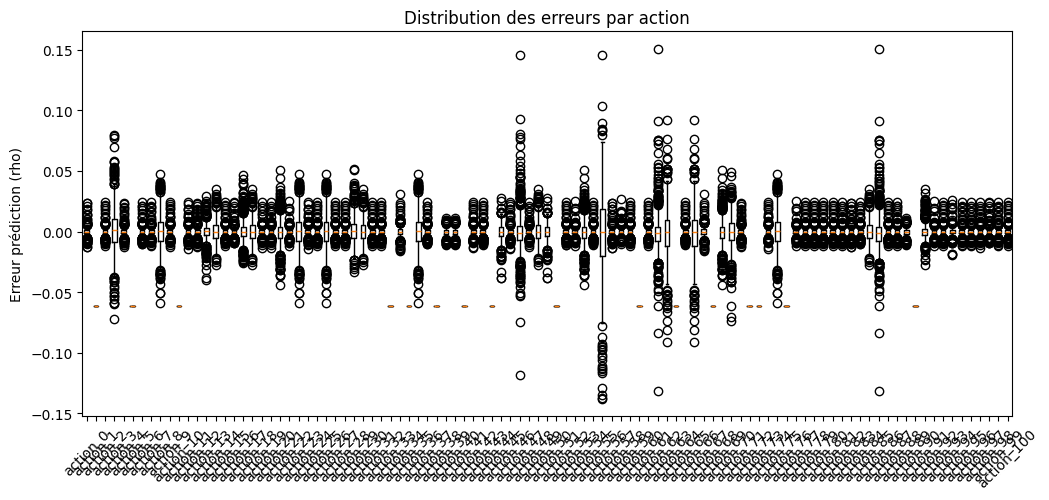

In [ ]:
errors = y_test.to_numpy() - y_pred
plt.figure(figsize=(12,5))
plt.boxplot(errors)
plt.xticks(range(1, y_test.shape[1]+1), [f"action_{i}" for i in range(y_test.shape[1])], rotation=45)
plt.ylabel("Erreur prédiction (rho)")
plt.title("Distribution des erreurs par action")
plt.show()